=4\7import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices: tf.config.experimental.set_memory_growth(device, True)


In [12]:
# import tensorflow as tf
# import numpy as np  # <-- Add this import

# # Load the model
# model = tf.keras.models.load_model(r"C:\Users\hp\Desktop\image-forgery-detection-main\trained_model.h5")  # Replace with your path

# # Check model architecture
# model.summary()

# # Test prediction (adjust input shape to match your model)
# dummy_input = np.random.rand(1, 128, 128, 3)  # Example for a 128x128 RGB image
# prediction = model.predict(dummy_input)
# print("Prediction shape:", prediction.shape)

In [13]:
# from tensorflow.keras.layers import Input

# model = Sequential([
#     Input(shape=(128, 128, 3)),  # Add this line
#     Conv2D(32, kernel_size=(3, 3)),  # Remove `input_shape` from here
#     # ... other layers ...
# ])

### Import necessary libraries

In [14]:
import numpy as np
import os
import itertools
import matplotlib.pyplot as plt
import json
import seaborn as sns

%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, Activation, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from PIL import Image, ImageChops, ImageEnhance
from tqdm.notebook import tqdm

### Error Level Analysis

In [15]:
#converts input image to ela applied image
def convert_to_ela_image(path,quality):

    original_image = Image.open(path).convert('RGB')

    #resaving input image at the desired quality
    resaved_file_name = 'resaved_image.jpg'     #predefined filename for resaved image
    original_image.save(resaved_file_name,'JPEG',quality=quality)
    resaved_image = Image.open(resaved_file_name)

    #pixel difference between original and resaved image
    ela_image = ImageChops.difference(original_image,resaved_image)
    
    #scaling factors are calculated from pixel extremas
    extrema = ela_image.getextrema()
    max_difference = max([pix[1] for pix in extrema])
    if max_difference ==0:
        max_difference = 1
    scale = 350.0 / max_difference
    
    #enhancing elaimage to brighten the pixels
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    ela_image.save("ela_image.png")
    return ela_image

### Dataset Preparation

In [16]:
def prepare_image(image_path):
    image_size = (128, 128)
    return np.array(convert_to_ela_image(image_path, 90).resize(image_size)).flatten() / 255.0         #normalizing the array values obtained from input image

In [17]:
X = [] # ELA converted images
Y = [] # 0 for fake, 1 for real

In [18]:
#adding authentic images

path = r"C:\Users\hp\Desktop\image-forgery-detection-main\dataset\CASIA2\Au"       #folder path of the authentic images in the dataset
for filename in tqdm(os.listdir(path),desc="Processing Images : "):
    if filename.endswith('jpg') or filename.endswith('png'):
        full_path = os.path.join(path, filename)
        X.append(prepare_image(full_path))        
        Y.append(1)     # label                                                                                                                         111111111111111 for authentic images 
        
print(f'Total images: {len(X)}\nTotal labels: {len(Y)}')

Processing Images :   0%|          | 0/7492 [00:00<?, ?it/s]

Total images: 7354
Total labels: 7354


In [19]:
#adding forged images

path = r'C:\Users\hp\Desktop\image-forgery-detection-main\dataset\CASIA2\Tp'       #folder path of the forged images in the dataset
for filename in tqdm(os.listdir(path),desc="Processing Images : "):
    if filename.endswith('jpg') or filename.endswith('png'):
        full_path = os.path.join(path, filename)
        X.append(prepare_image(full_path))        
        Y.append(0)     # label for forged images 
        
print(f'Total images: {len(X)}\nTotal labels: {len(Y)}')

Processing Images :   0%|          | 0/5124 [00:00<?, ?it/s]

Total images: 9418
Total labels: 9418


In [20]:
# # import numpy as np 
# # X = np.array(X)
# # Y = np.array(Y)
# # X = X.reshape(-1, 128, 128, 3) 
# import numpy as np
# from PIL import Image
# import os

# # 1. First create empty lists to store data
# X = []  # This will store image data
# Y = []  # This will store labels (0 for fake, 1 for real)

# # 2. Process your images and fill X and Y
# # (Example - you need to implement your actual image loading loop here)
# for image_path in your_image_paths_list:
#     # Process image and get label
#     processed_img = prepare_image(image_path)  # Your ELA function
#     label = 0 if "fake" in image_path else 1  # Example label logic
    
#     X.append(processed_img)
#     Y.append(label)

# # 3. Now convert to numpy arrays and reshape
# X = np.array(X)
# Y = np.array(Y)
# X = X.reshape(-1, 128, 128, 3)  # Reshape for CNN input

# # Verify shapes
# print("X shape:", X.shape)  # Should be (num_images, 128, 128, 3)
# print("Y shape:", Y.shape)  # Should be (num_images,)

import numpy as np
import os
from tqdm import tqdm  # for progress bar

# 1. First create empty lists
X = []  # For image data
Y = []  # For labels (0=fake, 1=real)

# 2. Define your image directories
real_images_dir = r"C:\Users\hp\Desktop\image-forgery-detection-main\dataset\CASIA2\Au"  # ← Replace with your actual path
fake_images_dir = r"C:\Users\hp\Desktop\image-forgery-detection-main\dataset\CASIA2\Tp"  # ← Replace with your actual path

# 3. Get list of image paths
def get_image_paths(directory):
    """Returns list of image paths in a directory"""
    return [os.path.join(directory, f) for f in os.listdir(directory) 
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

# 4. Process REAL images (label=1)
real_paths = get_image_paths(real_images_dir)
for path in tqdm(real_paths, desc="Processing Real Images"):
    try:
        X.append(prepare_image(path))  # Your ELA function
        Y.append(1)  # Label for real
    except Exception as e:
        print(f"Skipping {path}: {str(e)}")

# 5. Process FAKE images (label=0)
fake_paths = get_image_paths(fake_images_dir)
for path in tqdm(fake_paths, desc="Processing Fake Images"):
    try:
        X.append(prepare_image(path))  # Your ELA function
        Y.append(0)  # Label for fake
    except Exception as e:
        print(f"Skipping {path}: {str(e)}")

# 6. Convert to numpy arrays and reshape
X = np.array(X)
Y = np.array(Y)
X = X.reshape(-1, 128, 128, 3)  # Reshape for CNN

print(f"Final dataset shape - X: {X.shape}, Y: {Y.shape}")

Processing Fake Images: 100%|██████████| 2064/2064 [04:10<00:00,  8.23it/s]


Final dataset shape - X: (9501, 128, 128, 3), Y: (9501,)


### Partitioning dataset for training, validation and testing

In [21]:
# # Training : Validation : Testing = 76 : 19 : 5
# X_temp, X_test, Y_temp, Y_test = train_test_split(X, Y, test_size = 0.05, random_state=5)
# X_train, X_val, Y_train, Y_val = train_test_split(X_temp, Y_temp, test_size = 0.2, random_state=5)
# X = X.reshape(-1,1,1,1)

# print(f'Training images: {len(X_train)} , Training labels: {len(Y_train)}')
# print(f'Validation images: {len(X_val)} , Validation labels: {len(Y_val)}')
# print(f'Test images: {len(X_test)} , Test labels: {len(Y_test)}')
import numpy as np
from sklearn.model_selection import train_test_split

# 1. Convert lists to numpy arrays
X = np.array(X)  # Image data
Y = np.array(Y)  # Labels

# 2. Verify initial shapes
print("Before splitting:")
print(f"X shape: {X.shape}")
print(f"Y shape: {Y.shape}")

# 3. Split the data (76% train, 19% val, 5% test)
X_temp, X_test, Y_temp, Y_test = train_test_split(X, Y, test_size=0.05, random_state=5)
X_train, X_val, Y_train, Y_val = train_test_split(X_temp, Y_temp, test_size=0.2, random_state=5)

# 4. Print split shapes
print("\nAfter splitting:")
print(f"X_train: {X_train.shape}, Y_train: {Y_train.shape}")
print(f"X_val: {X_val.shape}, Y_val: {Y_val.shape}")
print(f"X_test: {X_test.shape}, Y_test: {Y_test.shape}")

# 5. Print split statistics
print("\nSplit Statistics:")
print(f"Training samples: {len(X_train)} ({len(X_train)/len(X):.1%})")
print(f"Validation samples: {len(X_val)} ({len(X_val)/len(X):.1%})")
print(f"Test samples: {len(X_test)} ({len(X_test)/len(X):.1%})")

# 6. Class distribution analysis
def print_class_distribution(y, name):
    unique, counts = np.unique(y, return_counts=True)
    print(f"\nClass distribution in {name}:")
    for cls, count in zip(unique, counts):
        print(f"  Class {cls}: {count} samples ({count/len(y):.1%})")

print_class_distribution(Y_train, "Training set")
print_class_distribution(Y_val, "Validation set")
print_class_distribution(Y_test, "Test set")

# 7. Optional: Reshape for CNN (if needed)
if len(X_train.shape) == 2:  # If flattened
    print("\nReshaping for CNN...")
    height, width, channels = 128, 128, 3  # Adjust to your image dimensions
    X_train = X_train.reshape(-1, height, width, channels)
    X_val = X_val.reshape(-1, height, width, channels)
    X_test = X_test.reshape(-1, height, width, channels)
    print(f"New X_train shape: {X_train.shape}")

Before splitting:
X shape: (9501, 128, 128, 3)
Y shape: (9501,)

After splitting:
X_train: (7220, 128, 128, 3), Y_train: (7220,)
X_val: (1805, 128, 128, 3), Y_val: (1805,)
X_test: (476, 128, 128, 3), Y_test: (476,)

Split Statistics:
Training samples: 7220 (76.0%)
Validation samples: 1805 (19.0%)
Test samples: 476 (5.0%)

Class distribution in Training set:
  Class 0: 1566 samples (21.7%)
  Class 1: 5654 samples (78.3%)

Class distribution in Validation set:
  Class 0: 396 samples (21.9%)
  Class 1: 1409 samples (78.1%)

Class distribution in Test set:
  Class 0: 102 samples (21.4%)
  Class 1: 374 samples (78.6%)


### CNN Model

In [22]:
def build_model():
    model = Sequential()  # Sequential Model
    model.add(Conv2D(filters = 64, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    model.add(Conv2D(filters = 64, kernel_size = (5, 5), padding = 'valid', activation = 'relu'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Conv2D(filters = 64, kernel_size = (5, 5), padding = 'valid', activation = 'relu'))
    model.add(Conv2D(filters = 64, kernel_size = (5, 5), padding = 'valid', activation = 'relu'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Conv2D(filters = 64, kernel_size = (5, 5), padding = 'valid', activation = 'relu'))
    model.add(Conv2D(filters = 64, kernel_size = (5, 5), padding = 'valid', activation = 'relu'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation = 'sigmoid'))
    return model

In [23]:
model = build_model()
model.summary()

c:\Users\hp\anaconda33\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 124, 124, 64)   │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 120, 120, 64)   │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 60, 60, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 52, 52, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 22, 22, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 18, 18, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 5, 5, 32)       │        51,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 568,449 (2.17 MB)

 Trainable params: 568,449 (2.17 MB)

 Non-trainable params: 0 (0.00 B)

### Model Training

In [24]:
epochs = 15
batch_size = 32


In [25]:
# #Optimizer
# init_lr = 1e-4   #learning rate for the optimizer
# optimizer = Adam(lr = init_lr, decay = init_lr/epochs) 
# model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

# Optimizer configuration
init_lr = 1e-4  # Initial learning rate
epochs = 15     # Total training epochs

# Correct way to define the optimizer (for TF 2.x+)
optimizer = Adam(learning_rate=init_lr) 

# For learning rate decay, use either:

# Option 1: Built-in decay (less flexible)
# optimizer = Adam(learning_rate=init_lr, decay=init_lr/epochs)

# Option 2: LearningRateScheduler (recommended)
def lr_decay(epoch, lr):
    return lr * 0.9 if (epoch+1) % 5 == 0 else lr  # Decay by 10% every 5 epochs

callbacks = [
    LearningRateScheduler(lr_decay, verbose=1),
    # Your other callbacks...
]

# Model compilation
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy', 
                      'Precision',
                      'Recall'])

In [26]:
#Early Stopping
early_stopping = EarlyStopping(monitor = 'val_accuracy',
                               min_delta = 0,
                               patience = 10,
                               verbose = 0,
                               mode = 'auto')

In [28]:
hist = model.fit(X_train,
                 Y_train,
                 batch_size = batch_size,
                 epochs = epochs,
                 validation_data = (X_val, Y_val),
                 callbacks = [early_stopping])

Epoch 1/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 1797s 8s/step - Precision: 0.7831 - Recall: 0.9644 - accuracy: 0.7705 - loss: 0.4832 - val_Precision: 0.9070 - val_Recall: 0.8928 - val_accuracy: 0.8449 - val_loss: 0.2906
Epoch 2/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 1489s 7s/step - Precision: 0.9373 - Recall: 0.8777 - accuracy: 0.8576 - loss: 0.2938 - val_Precision: 0.9418 - val_Recall: 0.8722 - val_accuracy: 0.8582 - val_loss: 0.2783
Epoch 3/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 1422s 6s/step - Precision: 0.9534 - Recall: 0.8695 - accuracy: 0.8631 - loss: 0.2713 - val_Precision: 0.9460 - val_Recall: 0.8708 - val_accuracy: 0.8604 - val_loss: 0.2714
Epoch 4/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 1511s 7s/step - Precision: 0.9519 - Recall: 0.8828 - accuracy: 0.8733 - loss: 0.2693 - val_Precision: 0.9555 - val_Recall: 0.8680 - val_accuracy: 0.8654 - val_loss: 0.2661
Epoch 5/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 1734s 8s/step - Precision: 0.9652 - Recall: 0.8679 - accuracy: 0.8710 - loss: 0.2577 - val_Precision: 0.9739 - v

In [30]:
# #save the model as a h5 file
# model.save('.h5') 

# # get the dictionary containing each metric and the loss for each epoch
# history_dict = hist.history

# # save it as a json file
# json.dump(history_dict, open('', 'w'))
# Save the model in the recommended .keras format instead of .h5
model.save('model.keras')  # or use any other filename with .keras extension

# Get the dictionary containing each metric and the loss for each epoch
history_dict = hist.history

# Save it as a json file (you were missing the filename)
json.dump(history_dict, open('history.json', 'w'))

### Plotting the training and validation curves

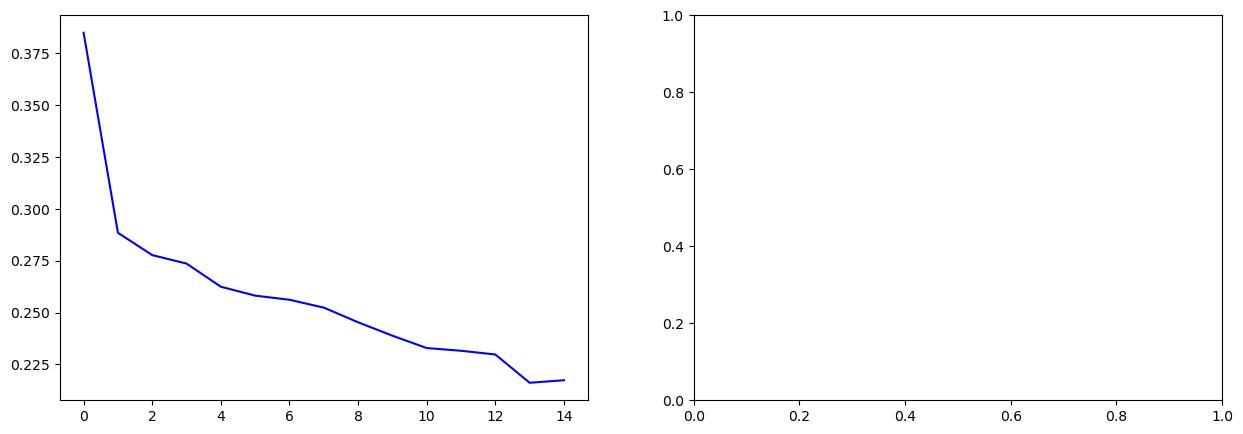

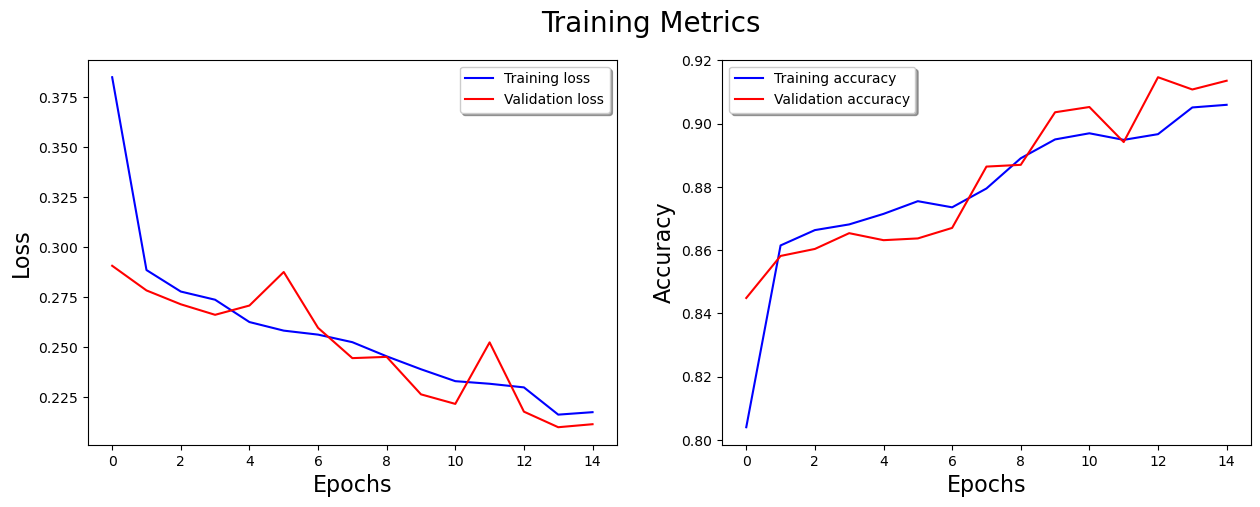

In [32]:
# fig, ax = plt.subplots(1,2,figsize=(15,5))

# #Figure 1
# ax[0].plot(history_dict['loss'], color='b', label = "Training loss")
# ax[0].plot(history_dict['val_loss'], color='r', label = "Validation loss",axes =ax[0])
# ax[0].set_xlabel('Epochs',fontsize=16)
# ax[0].set_ylabel('Loss',fontsize=16)
# legend = ax[0].legend(loc='best', shadow=True)

# #Figure 2
# ax[1].plot(history_dict['accuracy'], color='b', label = "Training accuracy")
# ax[1].plot(history_dict['val_accuracy'], color='r',label = "Validation accuracy")
# ax[1].set_xlabel('Epochs',fontsize=16)
# ax[1].set_ylabel('Accuracy',fontsize=16)
# legend = ax[1].legend(loc='best', shadow=True)

# fig.suptitle('Metrics',fontsize=20);
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Figure 1 - Loss
ax[0].plot(history_dict['loss'], color='b', label="Training loss")
ax[0].plot(history_dict['val_loss'], color='r', label="Validation loss")
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Loss', fontsize=16)
ax[0].legend(loc='best', shadow=True)

# Figure 2 - Accuracy
ax[1].plot(history_dict['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history_dict['val_accuracy'], color='r', label="Validation accuracy")
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Accuracy', fontsize=16)
ax[1].legend(loc='best', shadow=True)

fig.suptitle('Training Metrics', fontsize=20)
plt.show()

### Confusion Matrix

In [33]:
def plot_confusion_matrix(cf_matrix):
  
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()] #number of images in each classification block
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)] #percentage value of images in each block w.r.t total images

    axes_labels=['Forged', 'Authentic']
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='',cmap="flare" , xticklabels=axes_labels, yticklabels=axes_labels)

    plot_xlabel = plt.xlabel('Predicted labels', fontsize = 13)
    plot_ylabel = plt.ylabel('True labels', fontsize = 13)
    plot_title = plt.title('Confusion Matrix', fontsize= 10,fontweight='bold')

In [34]:
Y_pred = model.predict(X_val)               # Predict the values from the validation dataset 
Y_pred_classes = np.round(Y_pred)           # roundoff the sigmoid value
Y_true = Y_val                             

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)     # compute the confusion matrix
plot_confusion_matrix(confusion_mtx)                         # plot the confusion matrix


57/57 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step


### Classification Report

In [35]:
print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.78      0.85      0.81       396
           1       0.96      0.93      0.94      1409

    accuracy                           0.91      1805
   macro avg       0.87      0.89      0.88      1805
weighted avg       0.92      0.91      0.91      1805



### Testing Accuracy

In [36]:
class_names = ['Forged', 'Authentic']

In [38]:
# Testing accuracy
correct_test = 0 #correctly predicted test images
total_test = 0   #total test images

for index,image in enumerate(tqdm(X_test,desc="Processing Images : ")):
    image = image.reshape(-1, 128, 128, 3)
    y_pred = model.predict(image)
    y_pred_class = np.round(y_pred)
    total_test += 1
    if y_pred_class == Y_test[index]: #if prediction is correct
        correct_test += 1
    
print(f'Total test images: {total_test}\nCorrectly predicted images: {correct_test}\nAccuracy: {correct_test / total_test * 100.0} %')

Processing Images :   0%|          | 0/476 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


Processing Images :   0%|          | 1/476 [00:00<04:54,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Processing Images :   0%|          | 2/476 [00:00<03:32,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


Processing Images :   1%|          | 3/476 [00:01<03:31,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


Processing Images :   1%|          | 4/476 [00:01<03:34,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


Processing Images :   1%|          | 5/476 [00:02<03:41,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


Processing Images :   1%|▏         | 6/476 [00:02<03:54,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


Processing Images :   1%|▏         | 7/476 [00:03<03:41,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


Processing Images :   2%|▏         | 8/476 [00:03<03:42,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step


Processing Images :   2%|▏         | 9/476 [00:04<04:13,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


Processing Images :   2%|▏         | 10/476 [00:05<04:13,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 807ms/step


Processing Images :   2%|▏         | 11/476 [00:06<05:19,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


Processing Images :   3%|▎         | 12/476 [00:07<05:55,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step


Processing Images :   3%|▎         | 13/476 [00:07<06:16,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


Processing Images :   3%|▎         | 14/476 [00:08<05:32,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


Processing Images :   3%|▎         | 15/476 [00:08<04:42,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


Processing Images :   3%|▎         | 16/476 [00:09<04:10,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


Processing Images :   4%|▎         | 17/476 [00:09<03:49,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Processing Images :   4%|▍         | 18/476 [00:09<03:28,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


Processing Images :   4%|▍         | 19/476 [00:10<03:17,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


Processing Images :   4%|▍         | 20/476 [00:10<03:07,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


Processing Images :   4%|▍         | 21/476 [00:11<03:06,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Processing Images :   5%|▍         | 22/476 [00:11<02:53,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


Processing Images :   5%|▍         | 23/476 [00:11<03:03,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Processing Images :   5%|▌         | 24/476 [00:12<02:46,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


Processing Images :   5%|▌         | 25/476 [00:12<02:53,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Processing Images :   5%|▌         | 26/476 [00:12<02:43,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


Processing Images :   6%|▌         | 27/476 [00:13<02:56,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step


Processing Images :   6%|▌         | 28/476 [00:13<03:29,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


Processing Images :   6%|▌         | 29/476 [00:14<03:26,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


Processing Images :   6%|▋         | 30/476 [00:14<03:35,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


Processing Images :   7%|▋         | 31/476 [00:15<03:41,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


Processing Images :   7%|▋         | 32/476 [00:15<03:35,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Processing Images :   7%|▋         | 33/476 [00:16<03:15,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


Processing Images :   7%|▋         | 34/476 [00:16<03:31,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Processing Images :   7%|▋         | 35/476 [00:17<03:11,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


Processing Images :   8%|▊         | 36/476 [00:17<03:07,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


Processing Images :   8%|▊         | 37/476 [00:17<02:58,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


Processing Images :   8%|▊         | 38/476 [00:18<02:58,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


Processing Images :   8%|▊         | 39/476 [00:18<02:56,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Processing Images :   8%|▊         | 40/476 [00:19<02:48,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


Processing Images :   9%|▊         | 41/476 [00:19<02:49,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


Processing Images :   9%|▉         | 42/476 [00:19<02:46,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


Processing Images :   9%|▉         | 43/476 [00:20<02:51,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


Processing Images :   9%|▉         | 44/476 [00:20<02:50,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


Processing Images :   9%|▉         | 45/476 [00:21<03:17,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


Processing Images :  10%|▉         | 46/476 [00:21<03:30,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


Processing Images :  10%|▉         | 47/476 [00:22<03:32,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


Processing Images :  10%|█         | 48/476 [00:22<03:32,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


Processing Images :  10%|█         | 49/476 [00:23<03:39,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Processing Images :  11%|█         | 50/476 [00:23<03:32,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step


Processing Images :  11%|█         | 51/476 [00:24<04:00,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Processing Images :  11%|█         | 52/476 [00:24<03:27,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Processing Images :  11%|█         | 53/476 [00:25<03:01,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Processing Images :  11%|█▏        | 54/476 [00:25<02:44,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Processing Images :  12%|█▏        | 55/476 [00:25<02:35,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Processing Images :  12%|█▏        | 56/476 [00:26<02:28,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Processing Images :  12%|█▏        | 57/476 [00:26<02:26,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Processing Images :  12%|█▏        | 58/476 [00:26<02:21,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Processing Images :  12%|█▏        | 59/476 [00:27<02:16,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


Processing Images :  13%|█▎        | 60/476 [00:27<02:24,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Processing Images :  13%|█▎        | 61/476 [00:27<02:23,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


Processing Images :  13%|█▎        | 62/476 [00:28<02:38,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


Processing Images :  13%|█▎        | 63/476 [00:28<03:08,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


Processing Images :  13%|█▎        | 64/476 [00:29<03:07,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


Processing Images :  14%|█▎        | 65/476 [00:29<03:25,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


Processing Images :  14%|█▍        | 66/476 [00:30<03:21,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Processing Images :  14%|█▍        | 67/476 [00:30<03:00,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Processing Images :  14%|█▍        | 68/476 [00:31<02:46,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Processing Images :  14%|█▍        | 69/476 [00:31<02:38,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


Processing Images :  15%|█▍        | 70/476 [00:31<02:34,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Processing Images :  15%|█▍        | 71/476 [00:32<02:22,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


Processing Images :  15%|█▌        | 72/476 [00:32<02:29,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


Processing Images :  15%|█▌        | 73/476 [00:32<02:23,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Processing Images :  16%|█▌        | 74/476 [00:33<02:11,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Processing Images :  16%|█▌        | 75/476 [00:33<02:04,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


Processing Images :  16%|█▌        | 76/476 [00:33<02:29,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Processing Images :  16%|█▌        | 77/476 [00:34<02:20,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Processing Images :  16%|█▋        | 78/476 [00:34<02:15,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Processing Images :  17%|█▋        | 79/476 [00:34<02:14,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


Processing Images :  17%|█▋        | 80/476 [00:35<02:18,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


Processing Images :  17%|█▋        | 81/476 [00:35<03:06,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


Processing Images :  17%|█▋        | 82/476 [00:36<03:12,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


Processing Images :  17%|█▋        | 83/476 [00:37<03:16,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


Processing Images :  18%|█▊        | 84/476 [00:37<03:16,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


Processing Images :  18%|█▊        | 85/476 [00:38<03:12,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


Processing Images :  18%|█▊        | 86/476 [00:38<03:04,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Processing Images :  18%|█▊        | 87/476 [00:38<02:46,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


Processing Images :  18%|█▊        | 88/476 [00:39<02:36,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Processing Images :  19%|█▊        | 89/476 [00:39<02:30,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


Processing Images :  19%|█▉        | 90/476 [00:39<02:27,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Processing Images :  19%|█▉        | 91/476 [00:40<02:21,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


Processing Images :  19%|█▉        | 92/476 [00:40<02:25,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Processing Images :  20%|█▉        | 93/476 [00:40<02:21,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


Processing Images :  20%|█▉        | 94/476 [00:41<02:21,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Processing Images :  20%|█▉        | 95/476 [00:41<02:16,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


Processing Images :  20%|██        | 96/476 [00:42<02:25,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


Processing Images :  20%|██        | 97/476 [00:42<02:21,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


Processing Images :  21%|██        | 98/476 [00:42<02:23,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Processing Images :  21%|██        | 99/476 [00:43<02:11,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


Processing Images :  21%|██        | 100/476 [00:43<02:38,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step


Processing Images :  21%|██        | 101/476 [00:44<03:30,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


Processing Images :  21%|██▏       | 102/476 [00:45<03:34,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


Processing Images :  22%|██▏       | 103/476 [00:45<03:24,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


Processing Images :  22%|██▏       | 104/476 [00:46<03:06,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Processing Images :  22%|██▏       | 105/476 [00:46<02:47,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Processing Images :  22%|██▏       | 106/476 [00:46<02:40,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Processing Images :  22%|██▏       | 107/476 [00:47<02:29,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


Processing Images :  23%|██▎       | 108/476 [00:47<02:28,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Processing Images :  23%|██▎       | 109/476 [00:47<02:22,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


Processing Images :  23%|██▎       | 110/476 [00:48<02:28,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Processing Images :  23%|██▎       | 111/476 [00:48<02:21,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Processing Images :  24%|██▎       | 112/476 [00:49<02:21,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Processing Images :  24%|██▎       | 113/476 [00:49<02:15,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


Processing Images :  24%|██▍       | 114/476 [00:49<02:17,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Processing Images :  24%|██▍       | 115/476 [00:50<02:11,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


Processing Images :  24%|██▍       | 116/476 [00:50<02:19,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


Processing Images :  25%|██▍       | 117/476 [00:51<02:33,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


Processing Images :  25%|██▍       | 118/476 [00:51<02:46,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


Processing Images :  25%|██▌       | 119/476 [00:52<03:35,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


Processing Images :  25%|██▌       | 120/476 [00:52<03:10,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


Processing Images :  25%|██▌       | 121/476 [00:53<02:50,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Processing Images :  26%|██▌       | 122/476 [00:53<02:23,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


Processing Images :  26%|██▌       | 123/476 [00:53<02:13,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


Processing Images :  26%|██▌       | 124/476 [00:54<02:20,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


Processing Images :  26%|██▋       | 125/476 [00:54<02:17,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Processing Images :  26%|██▋       | 126/476 [00:54<02:12,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


Processing Images :  27%|██▋       | 127/476 [00:55<02:17,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


Processing Images :  27%|██▋       | 128/476 [00:55<02:31,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


Processing Images :  27%|██▋       | 129/476 [00:56<02:24,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


Processing Images :  27%|██▋       | 130/476 [00:56<02:18,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Processing Images :  28%|██▊       | 131/476 [00:57<02:13,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


Processing Images :  28%|██▊       | 132/476 [00:57<02:21,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


Processing Images :  28%|██▊       | 133/476 [00:58<02:37,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


Processing Images :  28%|██▊       | 134/476 [00:58<02:52,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


Processing Images :  28%|██▊       | 135/476 [00:59<03:00,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


Processing Images :  29%|██▊       | 136/476 [00:59<02:55,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


Processing Images :  29%|██▉       | 137/476 [01:00<02:55,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


Processing Images :  29%|██▉       | 138/476 [01:00<02:38,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


Processing Images :  29%|██▉       | 139/476 [01:00<02:27,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


Processing Images :  29%|██▉       | 140/476 [01:01<02:22,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


Processing Images :  30%|██▉       | 141/476 [01:01<02:24,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Processing Images :  30%|██▉       | 142/476 [01:02<02:05,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


Processing Images :  30%|███       | 143/476 [01:02<02:00,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Processing Images :  30%|███       | 144/476 [01:02<02:08,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


Processing Images :  30%|███       | 145/476 [01:03<02:10,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


Processing Images :  31%|███       | 146/476 [01:03<02:17,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Processing Images :  31%|███       | 147/476 [01:04<02:14,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


Processing Images :  31%|███       | 148/476 [01:04<02:24,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


Processing Images :  31%|███▏      | 149/476 [01:05<02:24,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


Processing Images :  32%|███▏      | 150/476 [01:05<02:39,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


Processing Images :  32%|███▏      | 151/476 [01:06<02:50,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


Processing Images :  32%|███▏      | 152/476 [01:06<02:51,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


Processing Images :  32%|███▏      | 153/476 [01:07<02:48,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Processing Images :  32%|███▏      | 154/476 [01:07<02:33,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


Processing Images :  33%|███▎      | 155/476 [01:08<02:27,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


Processing Images :  33%|███▎      | 156/476 [01:08<02:35,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


Processing Images :  33%|███▎      | 157/476 [01:09<02:29,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Processing Images :  33%|███▎      | 158/476 [01:09<02:20,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


Processing Images :  33%|███▎      | 159/476 [01:09<02:17,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Processing Images :  34%|███▎      | 160/476 [01:10<02:07,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


Processing Images :  34%|███▍      | 161/476 [01:10<02:06,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Processing Images :  34%|███▍      | 162/476 [01:10<02:01,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


Processing Images :  34%|███▍      | 163/476 [01:11<02:04,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


Processing Images :  34%|███▍      | 164/476 [01:11<02:14,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


Processing Images :  35%|███▍      | 165/476 [01:12<02:06,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


Processing Images :  35%|███▍      | 166/476 [01:12<02:11,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


Processing Images :  35%|███▌      | 167/476 [01:13<02:23,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


Processing Images :  35%|███▌      | 168/476 [01:13<02:23,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


Processing Images :  36%|███▌      | 169/476 [01:14<02:22,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


Processing Images :  36%|███▌      | 170/476 [01:14<02:25,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Processing Images :  36%|███▌      | 171/476 [01:15<02:18,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Processing Images :  36%|███▌      | 172/476 [01:15<02:06,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


Processing Images :  36%|███▋      | 173/476 [01:15<02:04,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


Processing Images :  37%|███▋      | 174/476 [01:16<02:09,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


Processing Images :  37%|███▋      | 175/476 [01:16<02:05,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


Processing Images :  37%|███▋      | 176/476 [01:17<02:05,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


Processing Images :  37%|███▋      | 177/476 [01:17<01:59,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


Processing Images :  37%|███▋      | 178/476 [01:17<02:03,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


Processing Images :  38%|███▊      | 179/476 [01:18<02:00,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


Processing Images :  38%|███▊      | 180/476 [01:18<02:09,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


Processing Images :  38%|███▊      | 181/476 [01:19<02:14,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


Processing Images :  38%|███▊      | 182/476 [01:19<02:23,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


Processing Images :  38%|███▊      | 183/476 [01:20<02:26,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step


Processing Images :  39%|███▊      | 184/476 [01:21<02:39,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


Processing Images :  39%|███▉      | 185/476 [01:22<03:22,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Processing Images :  39%|███▉      | 186/476 [01:22<02:43,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


Processing Images :  39%|███▉      | 187/476 [01:22<02:25,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


Processing Images :  39%|███▉      | 188/476 [01:23<02:09,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


Processing Images :  40%|███▉      | 189/476 [01:23<01:57,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Processing Images :  40%|███▉      | 190/476 [01:23<01:46,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step


Processing Images :  40%|████      | 191/476 [01:24<02:04,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


Processing Images :  40%|████      | 192/476 [01:24<02:01,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


Processing Images :  41%|████      | 193/476 [01:25<02:01,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


Processing Images :  41%|████      | 194/476 [01:25<02:01,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


Processing Images :  41%|████      | 195/476 [01:26<02:12,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


Processing Images :  41%|████      | 196/476 [01:26<02:08,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


Processing Images :  41%|████▏     | 197/476 [01:27<02:12,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


Processing Images :  42%|████▏     | 198/476 [01:27<02:25,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


Processing Images :  42%|████▏     | 199/476 [01:28<02:27,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step


Processing Images :  42%|████▏     | 200/476 [01:28<02:37,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


Processing Images :  42%|████▏     | 201/476 [01:29<02:42,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


Processing Images :  42%|████▏     | 202/476 [01:30<02:39,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Processing Images :  43%|████▎     | 203/476 [01:30<02:19,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


Processing Images :  43%|████▎     | 204/476 [01:30<02:10,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


Processing Images :  43%|████▎     | 205/476 [01:31<02:22,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


Processing Images :  43%|████▎     | 206/476 [01:31<02:11,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


Processing Images :  43%|████▎     | 207/476 [01:32<02:02,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Processing Images :  44%|████▎     | 208/476 [01:32<01:48,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


Processing Images :  44%|████▍     | 209/476 [01:32<01:46,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


Processing Images :  44%|████▍     | 210/476 [01:33<01:42,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


Processing Images :  44%|████▍     | 211/476 [01:33<01:40,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


Processing Images :  45%|████▍     | 212/476 [01:34<01:46,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Processing Images :  45%|████▍     | 213/476 [01:34<01:39,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


Processing Images :  45%|████▍     | 214/476 [01:34<01:40,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 902ms/step


Processing Images :  45%|████▌     | 215/476 [01:36<03:28,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


Processing Images :  45%|████▌     | 216/476 [01:37<03:00,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


Processing Images :  46%|████▌     | 217/476 [01:37<02:46,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


Processing Images :  46%|████▌     | 218/476 [01:37<02:28,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


Processing Images :  46%|████▌     | 219/476 [01:38<02:12,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


Processing Images :  46%|████▌     | 220/476 [01:38<02:02,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Processing Images :  46%|████▋     | 221/476 [01:39<01:55,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Processing Images :  47%|████▋     | 222/476 [01:39<01:51,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


Processing Images :  47%|████▋     | 223/476 [01:40<01:54,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


Processing Images :  47%|████▋     | 224/476 [01:40<01:50,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


Processing Images :  47%|████▋     | 225/476 [01:40<01:49,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


Processing Images :  47%|████▋     | 226/476 [01:41<01:47,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


Processing Images :  48%|████▊     | 227/476 [01:41<01:55,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


Processing Images :  48%|████▊     | 228/476 [01:42<02:04,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


Processing Images :  48%|████▊     | 229/476 [01:42<02:07,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


Processing Images :  48%|████▊     | 230/476 [01:43<01:59,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


Processing Images :  49%|████▊     | 231/476 [01:43<02:04,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step


Processing Images :  49%|████▊     | 232/476 [01:44<02:13,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


Processing Images :  49%|████▉     | 233/476 [01:45<02:20,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


Processing Images :  49%|████▉     | 234/476 [01:45<02:12,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Processing Images :  49%|████▉     | 235/476 [01:46<01:57,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


Processing Images :  50%|████▉     | 236/476 [01:46<01:53,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Processing Images :  50%|████▉     | 237/476 [01:46<01:45,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Processing Images :  50%|█████     | 238/476 [01:47<01:40,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


Processing Images :  50%|█████     | 239/476 [01:47<01:46,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


Processing Images :  50%|█████     | 240/476 [01:48<01:54,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


Processing Images :  51%|█████     | 241/476 [01:48<01:58,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step


Processing Images :  51%|█████     | 242/476 [01:49<02:29,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


Processing Images :  51%|█████     | 243/476 [01:50<02:28,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


Processing Images :  51%|█████▏    | 244/476 [01:51<02:27,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Processing Images :  51%|█████▏    | 245/476 [01:51<02:08,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


Processing Images :  52%|█████▏    | 246/476 [01:51<02:00,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


Processing Images :  52%|█████▏    | 247/476 [01:52<01:49,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


Processing Images :  52%|█████▏    | 248/476 [01:52<01:38,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


Processing Images :  52%|█████▏    | 249/476 [01:52<01:32,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Processing Images :  53%|█████▎    | 250/476 [01:53<01:22,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


Processing Images :  53%|█████▎    | 251/476 [01:53<01:19,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


Processing Images :  53%|█████▎    | 252/476 [01:53<01:22,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Processing Images :  53%|█████▎    | 253/476 [01:54<01:27,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Processing Images :  53%|█████▎    | 254/476 [01:54<01:18,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Processing Images :  54%|█████▎    | 255/476 [01:54<01:12,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Processing Images :  54%|█████▍    | 256/476 [01:55<01:07,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Processing Images :  54%|█████▍    | 257/476 [01:55<01:04,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


Processing Images :  54%|█████▍    | 258/476 [01:55<01:12,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


Processing Images :  54%|█████▍    | 259/476 [01:56<01:26,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


Processing Images :  55%|█████▍    | 260/476 [01:56<01:28,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


Processing Images :  55%|█████▍    | 261/476 [01:57<01:32,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


Processing Images :  55%|█████▌    | 262/476 [01:57<01:38,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


Processing Images :  55%|█████▌    | 263/476 [01:58<01:31,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


Processing Images :  55%|█████▌    | 264/476 [01:58<01:34,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Processing Images :  56%|█████▌    | 265/476 [01:58<01:22,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Processing Images :  56%|█████▌    | 266/476 [01:59<01:14,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Processing Images :  56%|█████▌    | 267/476 [01:59<01:07,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Processing Images :  56%|█████▋    | 268/476 [01:59<01:02,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Processing Images :  57%|█████▋    | 269/476 [02:00<01:04,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Processing Images :  57%|█████▋    | 270/476 [02:00<01:01,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


Processing Images :  57%|█████▋    | 271/476 [02:00<01:03,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Processing Images :  57%|█████▋    | 272/476 [02:00<00:59,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Processing Images :  57%|█████▋    | 273/476 [02:01<00:56,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Processing Images :  58%|█████▊    | 274/476 [02:01<00:56,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Processing Images :  58%|█████▊    | 275/476 [02:01<00:53,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


Processing Images :  58%|█████▊    | 276/476 [02:01<00:56,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Processing Images :  58%|█████▊    | 277/476 [02:02<00:53,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


Processing Images :  58%|█████▊    | 278/476 [02:02<00:56,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Processing Images :  59%|█████▊    | 279/476 [02:02<00:56,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


Processing Images :  59%|█████▉    | 280/476 [02:03<01:02,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


Processing Images :  59%|█████▉    | 281/476 [02:03<01:15,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step


Processing Images :  59%|█████▉    | 282/476 [02:04<01:28,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


Processing Images :  59%|█████▉    | 283/476 [02:04<01:30,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Processing Images :  60%|█████▉    | 284/476 [02:05<01:22,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Processing Images :  60%|█████▉    | 285/476 [02:05<01:13,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Processing Images :  60%|██████    | 286/476 [02:05<01:04,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Processing Images :  60%|██████    | 287/476 [02:06<01:01,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Processing Images :  61%|██████    | 288/476 [02:06<00:56,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Processing Images :  61%|██████    | 289/476 [02:06<00:54,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Processing Images :  61%|██████    | 290/476 [02:06<00:51,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Processing Images :  61%|██████    | 291/476 [02:07<00:49,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Processing Images :  61%|██████▏   | 292/476 [02:07<00:50,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Processing Images :  62%|██████▏   | 293/476 [02:07<00:48,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Processing Images :  62%|██████▏   | 294/476 [02:07<00:47,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Processing Images :  62%|██████▏   | 295/476 [02:08<00:47,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Processing Images :  62%|██████▏   | 296/476 [02:08<00:47,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Processing Images :  62%|██████▏   | 297/476 [02:08<00:49,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Processing Images :  63%|██████▎   | 298/476 [02:08<00:47,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Processing Images :  63%|██████▎   | 299/476 [02:09<00:46,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Processing Images :  63%|██████▎   | 300/476 [02:09<00:45,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Processing Images :  63%|██████▎   | 301/476 [02:09<00:44,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


Processing Images :  63%|██████▎   | 302/476 [02:09<00:46,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


Processing Images :  64%|██████▎   | 303/476 [02:10<01:01,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


Processing Images :  64%|██████▍   | 304/476 [02:10<01:04,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


Processing Images :  64%|██████▍   | 305/476 [02:11<01:11,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


Processing Images :  64%|██████▍   | 306/476 [02:11<01:09,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


Processing Images :  64%|██████▍   | 307/476 [02:12<01:09,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Processing Images :  65%|██████▍   | 308/476 [02:12<01:01,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


Processing Images :  65%|██████▍   | 309/476 [02:12<01:01,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Processing Images :  65%|██████▌   | 310/476 [02:13<00:57,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


Processing Images :  65%|██████▌   | 311/476 [02:13<00:58,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


Processing Images :  66%|██████▌   | 312/476 [02:13<00:56,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


Processing Images :  66%|██████▌   | 313/476 [02:14<00:54,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Processing Images :  66%|██████▌   | 314/476 [02:14<00:49,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


Processing Images :  66%|██████▌   | 315/476 [02:14<00:54,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Processing Images :  66%|██████▋   | 316/476 [02:15<00:49,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Processing Images :  67%|██████▋   | 317/476 [02:15<00:46,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Processing Images :  67%|██████▋   | 318/476 [02:15<00:46,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Processing Images :  67%|██████▋   | 319/476 [02:15<00:45,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


Processing Images :  67%|██████▋   | 320/476 [02:16<00:45,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Processing Images :  67%|██████▋   | 321/476 [02:16<00:43,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Processing Images :  68%|██████▊   | 322/476 [02:16<00:42,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Processing Images :  68%|██████▊   | 323/476 [02:17<00:42,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


Processing Images :  68%|██████▊   | 324/476 [02:17<00:46,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


Processing Images :  68%|██████▊   | 325/476 [02:17<00:53,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


Processing Images :  68%|██████▊   | 326/476 [02:18<00:58,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


Processing Images :  69%|██████▊   | 327/476 [02:18<01:03,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Processing Images :  69%|██████▉   | 328/476 [02:19<00:58,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Processing Images :  69%|██████▉   | 329/476 [02:19<00:51,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


Processing Images :  69%|██████▉   | 330/476 [02:19<00:50,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Processing Images :  70%|██████▉   | 331/476 [02:20<00:47,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


Processing Images :  70%|██████▉   | 332/476 [02:20<00:46,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Processing Images :  70%|██████▉   | 333/476 [02:20<00:43,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Processing Images :  70%|███████   | 334/476 [02:20<00:41,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Processing Images :  70%|███████   | 335/476 [02:21<00:40,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Processing Images :  71%|███████   | 336/476 [02:21<00:38,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


Processing Images :  71%|███████   | 337/476 [02:21<00:39,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Processing Images :  71%|███████   | 338/476 [02:21<00:38,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Processing Images :  71%|███████   | 339/476 [02:22<00:37,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


Processing Images :  71%|███████▏  | 340/476 [02:22<00:39,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Processing Images :  72%|███████▏  | 341/476 [02:22<00:45,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


Processing Images :  72%|███████▏  | 342/476 [02:23<00:51,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step


Processing Images :  72%|███████▏  | 343/476 [02:24<00:57,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


Processing Images :  72%|███████▏  | 344/476 [02:24<01:02,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


Processing Images :  72%|███████▏  | 345/476 [02:25<01:01,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


Processing Images :  73%|███████▎  | 346/476 [02:25<00:57,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


Processing Images :  73%|███████▎  | 347/476 [02:25<00:56,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Processing Images :  73%|███████▎  | 348/476 [02:26<00:48,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


Processing Images :  73%|███████▎  | 349/476 [02:26<00:45,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Processing Images :  74%|███████▎  | 350/476 [02:26<00:40,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Processing Images :  74%|███████▎  | 351/476 [02:26<00:37,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Processing Images :  74%|███████▍  | 352/476 [02:27<00:35,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Processing Images :  74%|███████▍  | 353/476 [02:27<00:34,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


Processing Images :  74%|███████▍  | 354/476 [02:27<00:36,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Processing Images :  75%|███████▍  | 355/476 [02:28<00:34,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Processing Images :  75%|███████▍  | 356/476 [02:28<00:34,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Processing Images :  75%|███████▌  | 357/476 [02:28<00:33,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Processing Images :  75%|███████▌  | 358/476 [02:28<00:32,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Processing Images :  75%|███████▌  | 359/476 [02:29<00:33,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


Processing Images :  76%|███████▌  | 360/476 [02:29<00:36,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Processing Images :  76%|███████▌  | 361/476 [02:29<00:35,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Processing Images :  76%|███████▌  | 362/476 [02:30<00:33,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


Processing Images :  76%|███████▋  | 363/476 [02:30<00:33,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Processing Images :  76%|███████▋  | 364/476 [02:30<00:38,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


Processing Images :  77%|███████▋  | 365/476 [02:31<00:44,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


Processing Images :  77%|███████▋  | 366/476 [02:31<00:48,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


Processing Images :  77%|███████▋  | 367/476 [02:32<00:50,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


Processing Images :  77%|███████▋  | 368/476 [02:32<00:53,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


Processing Images :  78%|███████▊  | 369/476 [02:33<00:48,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Processing Images :  78%|███████▊  | 370/476 [02:33<00:41,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Processing Images :  78%|███████▊  | 371/476 [02:33<00:37,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


Processing Images :  78%|███████▊  | 372/476 [02:34<00:36,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


Processing Images :  78%|███████▊  | 373/476 [02:34<00:37,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Processing Images :  79%|███████▊  | 374/476 [02:34<00:33,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Processing Images :  79%|███████▉  | 375/476 [02:35<00:31,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Processing Images :  79%|███████▉  | 376/476 [02:35<00:29,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Processing Images :  79%|███████▉  | 377/476 [02:35<00:28,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


Processing Images :  79%|███████▉  | 378/476 [02:35<00:29,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


Processing Images :  80%|███████▉  | 379/476 [02:36<00:29,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Processing Images :  80%|███████▉  | 380/476 [02:36<00:27,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Processing Images :  80%|████████  | 381/476 [02:36<00:27,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Processing Images :  80%|████████  | 382/476 [02:37<00:26,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Processing Images :  80%|████████  | 383/476 [02:37<00:25,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Processing Images :  81%|████████  | 384/476 [02:37<00:25,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


Processing Images :  81%|████████  | 385/476 [02:37<00:26,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


Processing Images :  81%|████████  | 386/476 [02:38<00:33,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


Processing Images :  81%|████████▏ | 387/476 [02:39<00:37,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


Processing Images :  82%|████████▏ | 388/476 [02:39<00:36,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


Processing Images :  82%|████████▏ | 389/476 [02:39<00:38,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Processing Images :  82%|████████▏ | 390/476 [02:40<00:33,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Processing Images :  82%|████████▏ | 391/476 [02:40<00:30,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Processing Images :  82%|████████▏ | 392/476 [02:40<00:27,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Processing Images :  83%|████████▎ | 393/476 [02:41<00:25,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Processing Images :  83%|████████▎ | 394/476 [02:41<00:24,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Processing Images :  83%|████████▎ | 395/476 [02:41<00:23,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Processing Images :  83%|████████▎ | 396/476 [02:41<00:23,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


Processing Images :  83%|████████▎ | 397/476 [02:42<00:25,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


Processing Images :  84%|████████▎ | 398/476 [02:42<00:27,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


Processing Images :  84%|████████▍ | 399/476 [02:43<00:31,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


Processing Images :  84%|████████▍ | 400/476 [02:43<00:31,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


Processing Images :  84%|████████▍ | 401/476 [02:44<00:31,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


Processing Images :  84%|████████▍ | 402/476 [02:44<00:34,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


Processing Images :  85%|████████▍ | 403/476 [02:45<00:33,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


Processing Images :  85%|████████▍ | 404/476 [02:45<00:33,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


Processing Images :  85%|████████▌ | 405/476 [02:46<00:33,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


Processing Images :  85%|████████▌ | 406/476 [02:46<00:32,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


Processing Images :  86%|████████▌ | 407/476 [02:46<00:30,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Processing Images :  86%|████████▌ | 408/476 [02:47<00:26,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Processing Images :  86%|████████▌ | 409/476 [02:47<00:24,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Processing Images :  86%|████████▌ | 410/476 [02:47<00:22,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


Processing Images :  86%|████████▋ | 411/476 [02:48<00:25,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Processing Images :  87%|████████▋ | 412/476 [02:48<00:22,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Processing Images :  87%|████████▋ | 413/476 [02:48<00:21,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Processing Images :  87%|████████▋ | 414/476 [02:49<00:19,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Processing Images :  87%|████████▋ | 415/476 [02:49<00:18,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Processing Images :  87%|████████▋ | 416/476 [02:49<00:18,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Processing Images :  88%|████████▊ | 417/476 [02:49<00:16,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


Processing Images :  88%|████████▊ | 418/476 [02:50<00:16,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Processing Images :  88%|████████▊ | 419/476 [02:50<00:15,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Processing Images :  88%|████████▊ | 420/476 [02:50<00:14,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Processing Images :  88%|████████▊ | 421/476 [02:50<00:14,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Processing Images :  89%|████████▊ | 422/476 [02:51<00:14,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


Processing Images :  89%|████████▉ | 423/476 [02:51<00:15,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


Processing Images :  89%|████████▉ | 424/476 [02:52<00:18,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


Processing Images :  89%|████████▉ | 425/476 [02:52<00:21,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


Processing Images :  89%|████████▉ | 426/476 [02:53<00:22,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


Processing Images :  90%|████████▉ | 427/476 [02:53<00:22,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


Processing Images :  90%|████████▉ | 428/476 [02:54<00:20,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


Processing Images :  90%|█████████ | 429/476 [02:54<00:23,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


Processing Images :  90%|█████████ | 430/476 [02:55<00:23,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Processing Images :  91%|█████████ | 431/476 [02:55<00:19,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Processing Images :  91%|█████████ | 432/476 [02:55<00:17,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Processing Images :  91%|█████████ | 433/476 [02:56<00:15,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Processing Images :  91%|█████████ | 434/476 [02:56<00:14,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Processing Images :  91%|█████████▏| 435/476 [02:56<00:12,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Processing Images :  92%|█████████▏| 436/476 [02:56<00:12,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Processing Images :  92%|█████████▏| 437/476 [02:57<00:11,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Processing Images :  92%|█████████▏| 438/476 [02:57<00:10,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Processing Images :  92%|█████████▏| 439/476 [02:57<00:10,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Processing Images :  92%|█████████▏| 440/476 [02:57<00:09,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Processing Images :  93%|█████████▎| 441/476 [02:58<00:09,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Processing Images :  93%|█████████▎| 442/476 [02:58<00:08,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Processing Images :  93%|█████████▎| 443/476 [02:58<00:08,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


Processing Images :  93%|█████████▎| 444/476 [02:59<00:10,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


Processing Images :  93%|█████████▎| 445/476 [02:59<00:11,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


Processing Images :  94%|█████████▎| 446/476 [03:00<00:12,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


Processing Images :  94%|█████████▍| 447/476 [03:00<00:12,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


Processing Images :  94%|█████████▍| 448/476 [03:01<00:11,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Processing Images :  94%|█████████▍| 449/476 [03:01<00:09,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Processing Images :  95%|█████████▍| 450/476 [03:01<00:08,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Processing Images :  95%|█████████▍| 451/476 [03:01<00:07,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Processing Images :  95%|█████████▍| 452/476 [03:02<00:07,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


Processing Images :  95%|█████████▌| 453/476 [03:02<00:06,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


Processing Images :  95%|█████████▌| 454/476 [03:02<00:06,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


Processing Images :  96%|█████████▌| 455/476 [03:02<00:06,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Processing Images :  96%|█████████▌| 456/476 [03:03<00:05,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


Processing Images :  96%|█████████▌| 457/476 [03:03<00:06,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


Processing Images :  96%|█████████▌| 458/476 [03:04<00:08,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Processing Images :  96%|█████████▋| 459/476 [03:04<00:07,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Processing Images :  97%|█████████▋| 460/476 [03:05<00:06,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Processing Images :  97%|█████████▋| 461/476 [03:05<00:05,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


Processing Images :  97%|█████████▋| 462/476 [03:05<00:04,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Processing Images :  97%|█████████▋| 463/476 [03:06<00:04,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


Processing Images :  97%|█████████▋| 464/476 [03:06<00:04,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


Processing Images :  98%|█████████▊| 465/476 [03:06<00:04,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


Processing Images :  98%|█████████▊| 466/476 [03:07<00:04,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


Processing Images :  98%|█████████▊| 467/476 [03:07<00:03,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Processing Images :  98%|█████████▊| 468/476 [03:07<00:02,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Processing Images :  99%|█████████▊| 469/476 [03:08<00:02,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Processing Images :  99%|█████████▊| 470/476 [03:08<00:01,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Processing Images :  99%|█████████▉| 471/476 [03:08<00:01,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Processing Images :  99%|█████████▉| 472/476 [03:09<00:01,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Processing Images :  99%|█████████▉| 473/476 [03:09<00:00,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Processing Images : 100%|█████████▉| 474/476 [03:09<00:00,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Processing Images : 100%|█████████▉| 475/476 [03:09<00:00,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Processing Images : 100%|██████████| 476/476 [03:10<00:00,  2.50it/s]

Total test images: 476
Correctly predicted images: 428
Accuracy: 89.91596638655463 %


# Test an image

c:\Users\hp\anaconda33\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 18 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step
Prediction: Authentic
Confidence: 100.00%


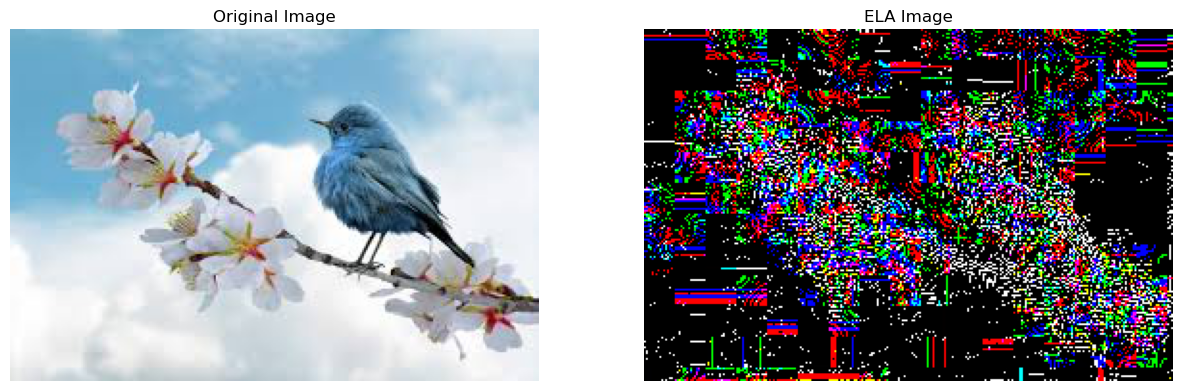

In [5]:

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from tensorflow.keras.models import load_model  # Add this import

def prepare_image(image_path):
    """Resize and normalize image for model prediction"""
    img = Image.open(image_path).resize((128, 128))
    img = np.array(img)/255.0
    return img

def convert_to_ela_image(image_path, quality=90):
    """Generate ELA image"""
    temp_filename = 'temp.jpg'
    original = Image.open(image_path)
    original.save(temp_filename, 'JPEG', quality=quality)
    compressed = Image.open(temp_filename)
    ela_image = np.array(original) - np.array(compressed)
    os.remove(temp_filename)
    return ela_image


model = load_model('model.keras')  


test_image_path = r"C:\Users\hp\Downloads\images.jpg" #test image path

test_image = prepare_image(test_image_path)
test_image = test_image.reshape(-1, 128, 128, 3)

y_pred = model.predict(test_image)
y_pred_class = round(y_pred[0][0])

fig, ax = plt.subplots(1,2,figsize=(15,5)) 

original_image = plt.imread(test_image_path) 
ax[0].imshow(original_image)
ax[0].axis('off')
ax[0].set_title('Original Image')

ax[1].imshow(convert_to_ela_image(test_image_path,90)) 
ax[1].axis('off')
ax[1].set_title('ELA Image')

class_names = ["Forged", "Authentic"]
print(f'Prediction: {class_names[y_pred_class]}')
print(f'Confidence: {max(y_pred[0][0], 1-y_pred[0][0]) * 100:.2f}%')

plt.show()

# Test a dataset

In [44]:
import os
from tqdm import tqdm
import numpy as np

# 1. SET YOUR ACTUAL PATH HERE
test_folder_path = r'C:\Users\hp\Desktop\image-forgery-detection-main\dataset\CASIA1'

# 2. VERIFICATION
print("\n=== Path Verification ===")
print(f"Path exists: {os.path.exists(test_folder_path)}")
if os.path.exists(test_folder_path):
    sample_files = [f for f in os.listdir(test_folder_path) if not f.startswith('.')]
    print(f"Found {len(sample_files)} files (first 5: {sample_files[:5]})")

# 3. PROCESSING
if os.path.exists(test_folder_path) and any(f.lower().endswith(('jpg','png','jpeg')) for f in os.listdir(test_folder_path)):
    authentic = forged = total = errors = 0
    
    for filename in tqdm(os.listdir(test_folder_path)):
        if filename.lower().endswith(('jpg','png','jpeg')) and not filename.startswith('.'):
            try:
                img_path = os.path.join(test_folder_path, filename)
                img = prepare_image(img_path).reshape(-1, 128, 128, 3)
                pred = model.predict(img)[0][0]
                total += 1
                if np.round(pred) == 0:
                    forged += 1
                else:
                    authentic += 1
            except Exception as e:
                errors += 1
                print(f"Error processing {filename}: {str(e)}")
                continue

    # 4. RESULTS
    print("\n=== Results ===")
    print(f"Total images processed: {total}")
    print(f"Processing errors: {errors}")
    
    if total > 0:
        print(f"\nAuthentic Images: {authentic} ({authentic/total*100:.1f}%)")
        print(f"Forged Images: {forged} ({forged/total*100:.1f}%)")
    else:
        print("\nNo images were successfully processed.")
else:
    print("\nERROR: No valid images found. Check:")
    print(f"1. Path is correct: {test_folder_path}")
    print("2. Folder contains JPG/PNG/JPEG files")
    print("3. Files don't have hidden prefixes")

# test_folder_path = r'C:\Users\hp\Desktop\image-forgery-detection-main\dataset\CASIA1'          #dataset path
# authentic,forged,total = 0,0,0

# for filename in tqdm(os.listdir(test_folder_path),desc="Processing Images : "):
#     if filename.endswith('jpg') or filename.endswith('png'):
#         test_image_path = os.path.join(path, filename)
#         test_image = prepare_image(test_image_path)  
#         test_image.reshape(-1, 128, 128, 3)
#         y_pred = model.predict(image)
#         y_pred_class = np.round(y_pred)
#         total += 1
#         if y_pred_class == 0:
#             forged += 1
#         else:
#             authentic +=1

# print(f'Total images: {total}\nAuthentic Images: {authentic}\nForged Images: {forged}')


=== Path Verification ===
Path exists: True
Found 5 files (first 5: ['01FixSize.py', 'Au', 'check.py', 'extraction.py', 'Sp'])

ERROR: No valid images found. Check:
1. Path is correct: C:\Users\hp\Desktop\image-forgery-detection-main\dataset\CASIA1
2. Folder contains JPG/PNG/JPEG files
3. Files don't have hidden prefixes


In [45]:
import numpy as np
from tensorflow.keras.models import load_model

def verify_model(model_path, test_img_path):
    try:
        # 1. Load Model
        model = load_model(model_path)
        print("✅ Model loaded successfully")
        
        # 2. Check Architecture
        model.summary()
        
        # 3. Test Prediction
        test_img = prepare_image(test_img_path).reshape(1, 128, 128, 3)
        pred = model.predict(test_img)
        print(f"\nPrediction: {'Forged' if pred[0][0] < 0.5 else 'Authentic'} (Confidence: {max(pred[0][0], 1-pred[0][0])*100:.2f}%)")
        
        return True
    except Exception as e:
        print("❌ Verification failed:", str(e))
        return False

# Usage:
verify_model("forgery_detector.keras", r"C:\Users\hp\Desktop\test_image.jpg")

❌ Verification failed: File not found: filepath=forgery_detector.keras. Please ensure the file is an accessible `.keras` zip file.


False